# Clinic 4: UK Visitors Timeseries

*Hristo Minkov* - i6161227

In this clinic we are going to explore a dataset that represents the monthly total number of visits to the UK by overseas residents (in thousands) from January 1980 to December 2019 (inclusive). This assignment aims at exploring the data and running some tests for stationarity. In case of non-stationary data, the timeseries is transformed appropriately. Following, an ARIMA model is trained with pre-estimated parmeters. At the end, we evaluate the model and present the final conclusion. The specific structure of the assignment is as follows:

1. Loading the Data
2. Data Visualization
    1. Zooming on the 'Mad Cow Desease' event in 1996
    2. Zooming on the 'London Bombings' event in 2005
    3. Zooming on the 'Financial Crisis' event in 2008
3. What is the best time to visit the UK?
4. Data Exploration
    1. Data Trend
    2. Data Seasonality
        1. Seasonality on the 'Mad Cow Desease' event in 1996
        2. Seasonality on the 'London Bombings' event in 2005
        3. Seasonality on the 'Financial Crisis' event in 2008
    3. Data Residual
5. Data Preparaion
    1. Data Stationarity Check
    2. Augmented Dickey-Fuller (ADF) Unit Root Test
    3. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for Stationarity
    4. The Zivot-Andrews Unit Root Test
    5. Comparing Test Results
    6. Seasonal Statistics Visualization
    7. Stationarization
        1. Box-Cox Transformation
        2. Overall Trend Elimination with First-Difference (FD)
        3. Seasonality Elimination with Seasonal-Difference (SD)
        4. Comparing Test Results
6. Building an AutoRegressive Integrated Moving Average (ARIMA) Model
    1. AR / MA Parameters Estimation
    2. Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors (SARIMAX) Model
    3. Building the Model
    4. Model Predictions
    5. Model Predictions Visualization
    6. Model Predictions on the Test Set Visualization
    7. Model Predictions on the Test Set with Confidence Interval
    8. Model  Forecast Evaluation
    9. Seasonal Model Prediction Evaluation (12 months)
7. Clinic Conclusion

<img src="https://media.giphy.com/media/OF0yOAufcWLfi/giphy.gif" width="450"/>

## Loading the Data

This section includes all the necessary library imports, applies certain Matplotlib visualization parameters, loads the data without the headers and finally, displays the top rows from the timeseries and comments on the date range and number of data points.

In [35]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, zivot_andrews
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [36]:
df = pd.read_csv("GMAA-010119.csv", header=None, skiprows=7, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [37]:
df.head(5)

,period,value
0,1980-01-01,739
1,1980-02-01,602
2,1980-03-01,740
3,1980-04-01,1028
4,1980-05-01,1088


In [38]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1980 - 01.12.2019
Number of data points: 480 of expected 480


## Data Visualization

This section tries to visualize the entire data. It plots the number of UK visitors vs the respective period. Following, several important UK events are zoomed upon and described. These correspond to difficult periods from Great Britain's history and thus, they probably cause overall decline in tourist activity. After thoroughly exploring all the possible types of timeseries visualizations at https://www.datadoghq.com/blog/timeseries-metric-graphs-101/, the conclusion is that the current TS data for the number of UK visitors is best represented by the line graph below.

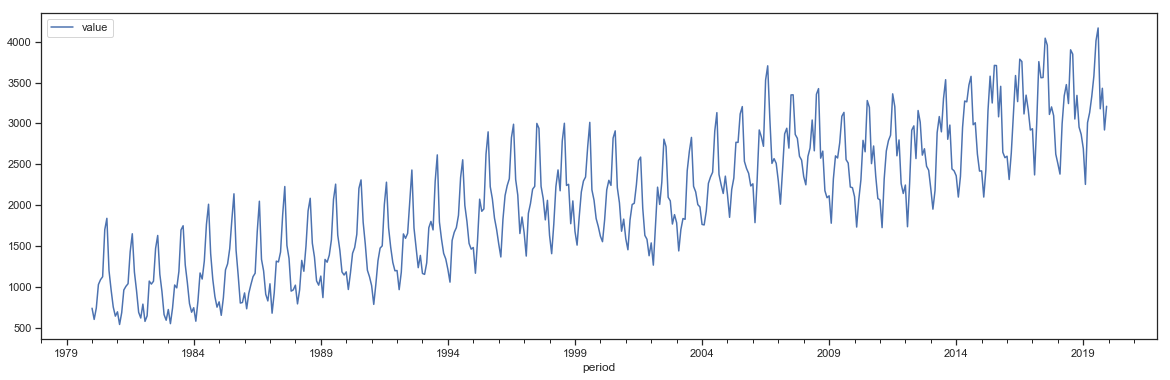

In [39]:
fig, ax = plt.subplots(figsize=(20,6))

df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')

### Zooming on the 'Mad Cow Desease' event in 1996
'Government announces that BSE, or 'mad cow disease', can be transmitted to humans. Crisis for beef industry follows, with mass slaughtering of animals, collapse of markets and export bans. Many beef farmers face financial ruin.'<br>
--- *source BBC* (https://www.bbc.com/news/world-europe-18028620)

We observe the period before and after the announcement. Therefore, the period of interest here is from year 1995 to year 1997 inclusive.

There appears to be not a significant increase/decrease over this period perhaps because the main affected industry is not the tourist one but the beef industry (slaughtering of animals, export bans, etc). Therefore, people just avoided eating beef but this would not stop them from visiting the UK.

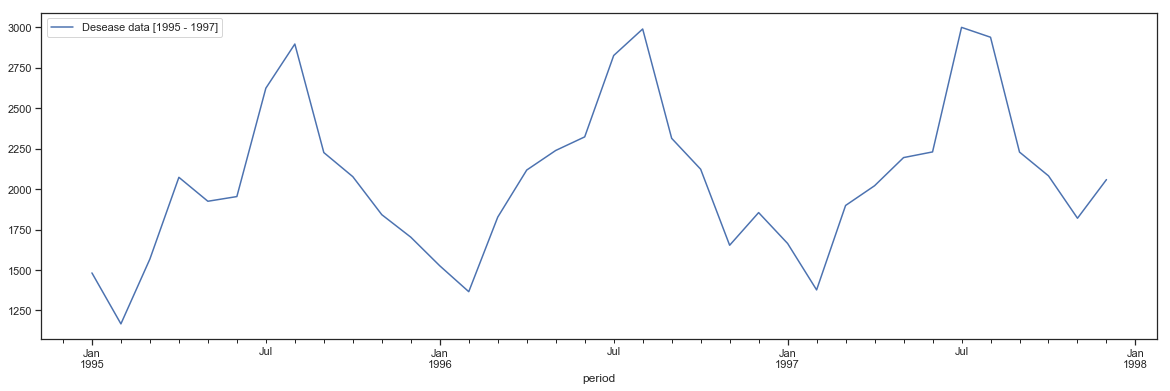

In [40]:
desease_zoom = df[(df.period >= '1995-01-01') & (df.period < '1998-01-01')].index

fig, ax = plt.subplots(figsize=(20,6))
df.loc[desease_zoom].plot(x="period", y="value", ax=ax, label="Desease data [1995 - 1997]")
plt.legend(loc='upper left')

### Zooming on the 'London Bombings' event in 2005
'7 July - 52 people are killed and around 700 are injured in four Islamist suicide bomb attacks on London's transport network. Two weeks later, more would-be bombers fail to detonate four devices on same network.'<br>
--- *source BBC* (https://www.bbc.com/news/world-europe-18028620)

We observe the period before and after the announcement. Therefore, the period of interest here is from year 2004 to year 2006 inclusive.

There appears to be a rather drastic increase in UK visits since 2006. Apparently, people were afraid of those repetitive un/sucessfull bombing attempts but as time passed by, they got relaxed again and that brought them back to the UK.

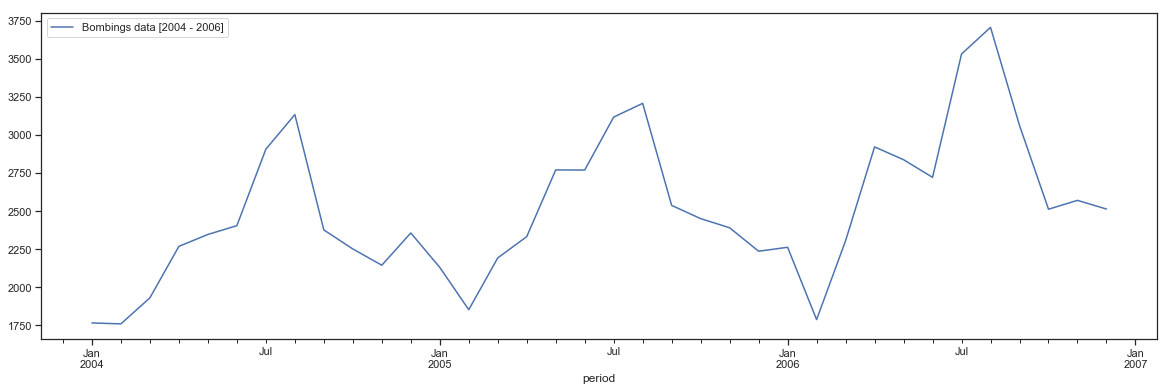

In [41]:
bombings_zoom = df[(df.period >= '2004-01-01') & (df.period < '2007-01-01')].index

fig, ax = plt.subplots(figsize=(20,6))
df.loc[bombings_zoom].plot(x="period", y="value", ax=ax, label="Bombings data [2004 - 2006]")
plt.legend(loc='upper left')

### Zooming on the 'Financial Crisis' event in 2008
'October - The government part-nationalises three leading UK banks with a 37 billion pound rescue package. It also pumps billions into the UK financial system after record stock market falls precipitated by the global "credit crunch".'<br>
--- *source BBC* (https://www.bbc.com/news/world-europe-18028620)

We observe the period before and after the announcement. Therefore, the period of interest here is from year 2007 to year 2009 inclusive.

The Financial crisis of 2008 hit hard not only the Uk, but overall the entire world. Therefore, foreign visitors might have stop themselves from leaving their home country as every additional trip costs money. One could imagine that it's not a great sight to go with a travelling agency around the country that just aims to 'survive'. Moreover, prices went up and people could not afford many activities troughout their trip, so they decided to stay home instead.

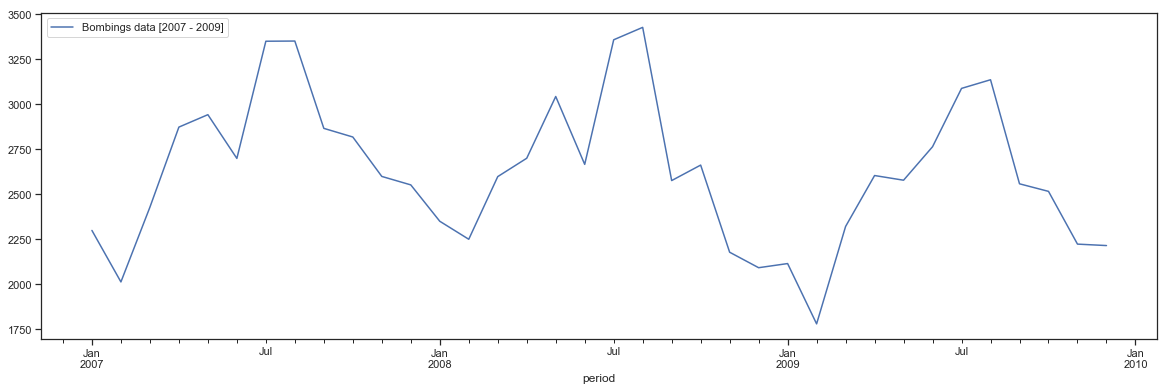

In [42]:
crisis_zoom = df[(df.period >= '2007-01-01') & (df.period < '2010-01-01')].index

fig, ax = plt.subplots(figsize=(20,6))
df.loc[crisis_zoom].plot(x="period", y="value", ax=ax, label="Bombings data [2007 - 2009]")
plt.legend(loc='upper left')

## What is the best time to visit the UK?

Based on the visualization above, the question of which is the preferrable time to visit the UK arises. To answer this inquiry, we need to evaluate what should mean for a time period to be better than the others. Of course, we will not look into all the years but rather in the data seasonality - which season/period from the year is better for a visitor. As most people dislike very crowded cities, we would suggest that the timeslot is not the one with most tourist. Moreover, we should not pick the cold season as UK tends to be very rainy and unpleasant. Therefore, suggest that the best time to visit the UK shall be between May and June - period where the tourist season hasn't already started and the weather begins to get better. Another thing to mention here is that a tourist should avoid visiting the UK in times of flu, crisis or any other inconvenient time slot.

## Data Exploration
We can see from the first plot of our data that there are seasonal/periodic fluctuations and that overall the number of people that visit the UK tend to go up. This leads us to the conclusion that the timeseries has the trend and seasonality characteristics. This assignment tries to tackle and decompose them using the *statsmodels* package into data trend, data seasonality and data residual (there is also a 4th property 'observed' which represents the actual data - since we have it either way, we won't comment on that decomposed property).

In [43]:
decomp = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=12,
    model='additive')

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

### Data Trend

The data trend property shows the overall tendency of the number of UK visitors to either increase or decrease. We can conclude from the following visualization that the trend over the entire period is clear - visitors to the UK are getting more and more. The number those so almost in a linear manner (apart from the few deviations from this statement).

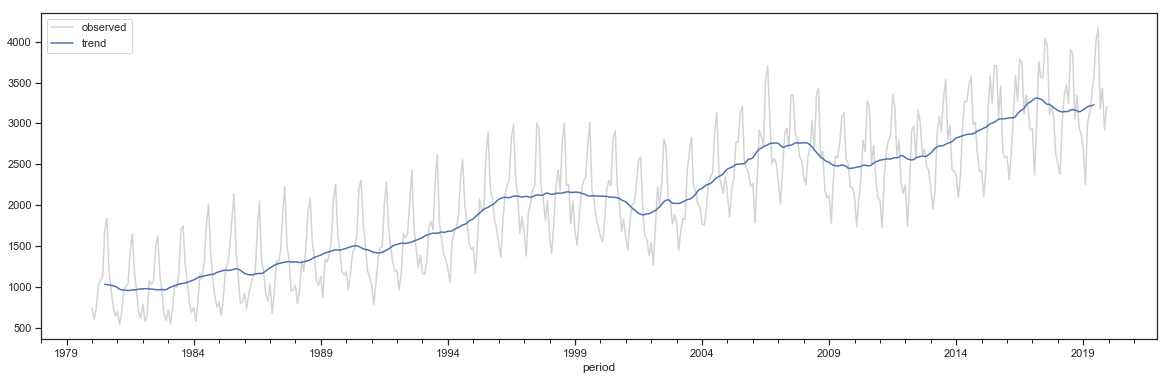

In [44]:
fig, ax = plt.subplots(figsize=(20, 6))

df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend")

plt.legend(loc='upper left')

### Data Seasonality

The data seasonality property showcases the general similarity between the same seasons in different years. The number of seasons within a year is set to be 12 - one for each month. We can clearly see that all the seasonal activity keeps the exact same pattern over the entire period. Following the main plot, there are 3 additional visualizations for the seasonality parameter for the 3 main events described above.

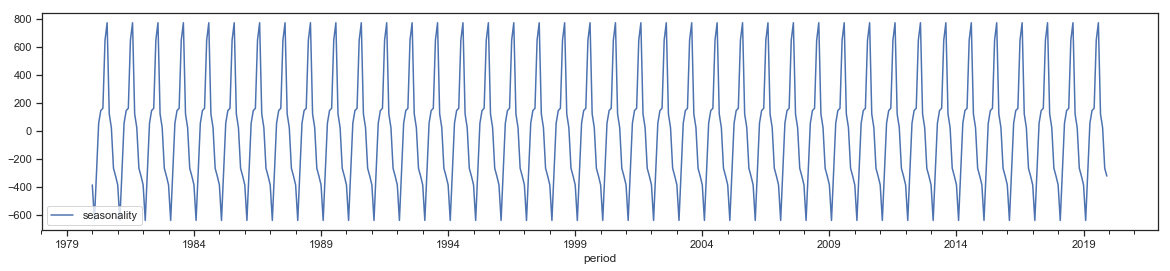

In [45]:
fig, ax = plt.subplots(figsize=(20, 4))

seasonal.plot(ax=ax, label="seasonality")

plt.legend(loc='lower left')

#### Seasonality on the 'Mad Cow Desease' event in 1996

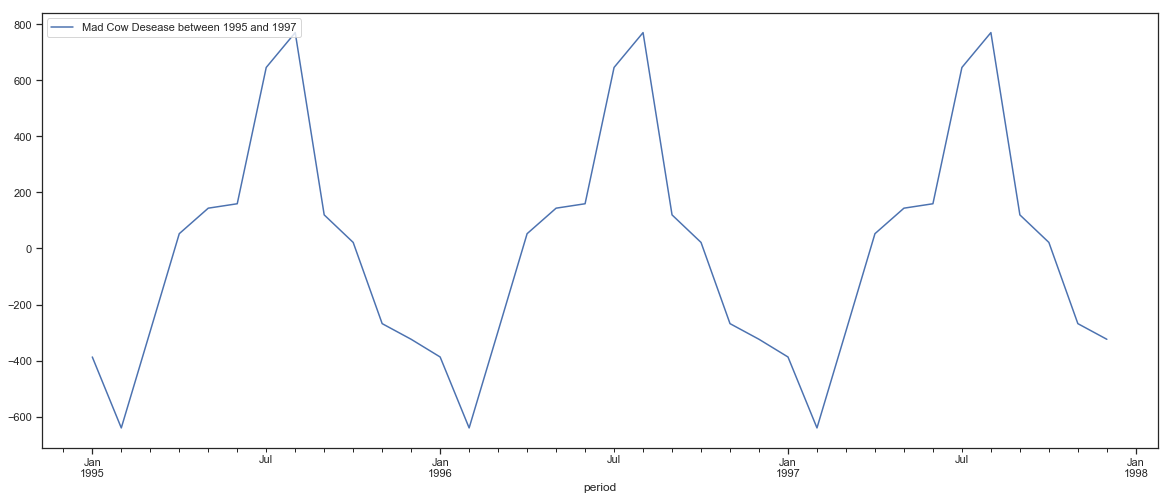

In [46]:
fig, ax = plt.subplots(figsize=(20, 8))

seasonal[desease_zoom].plot(x="period", y="value", ax=ax, label="Mad Cow Desease between 1995 and 1997")

plt.legend(loc='upper left')

#### Seasonality on the 'London Bombings' event in 2005

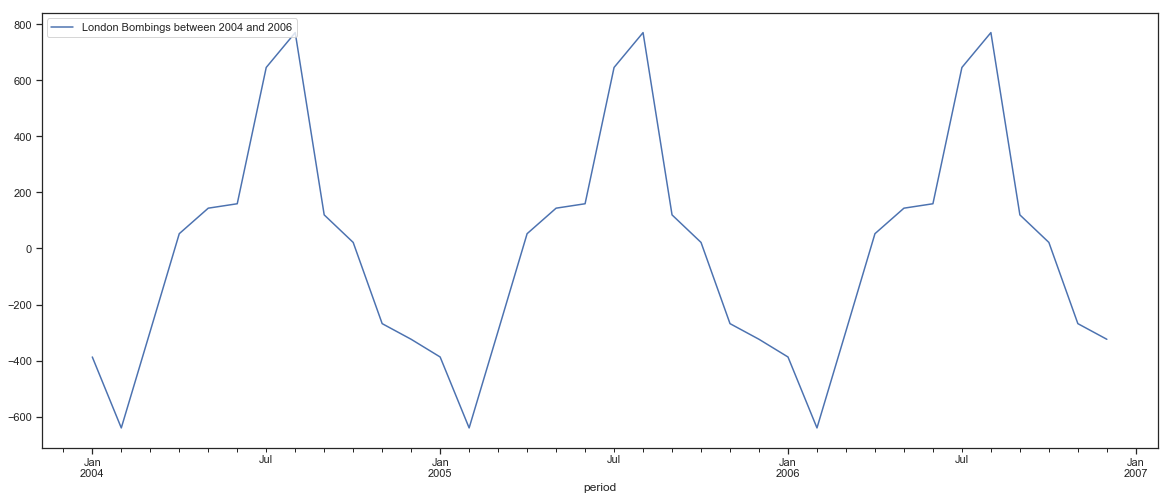

In [47]:
fig, ax = plt.subplots(figsize=(20, 8))

seasonal[bombings_zoom].plot(x="period", y="value", ax=ax, label="London Bombings between 2004 and 2006")

plt.legend(loc='upper left')

#### Seasonality on the 'Financial Crisis' event in 2008

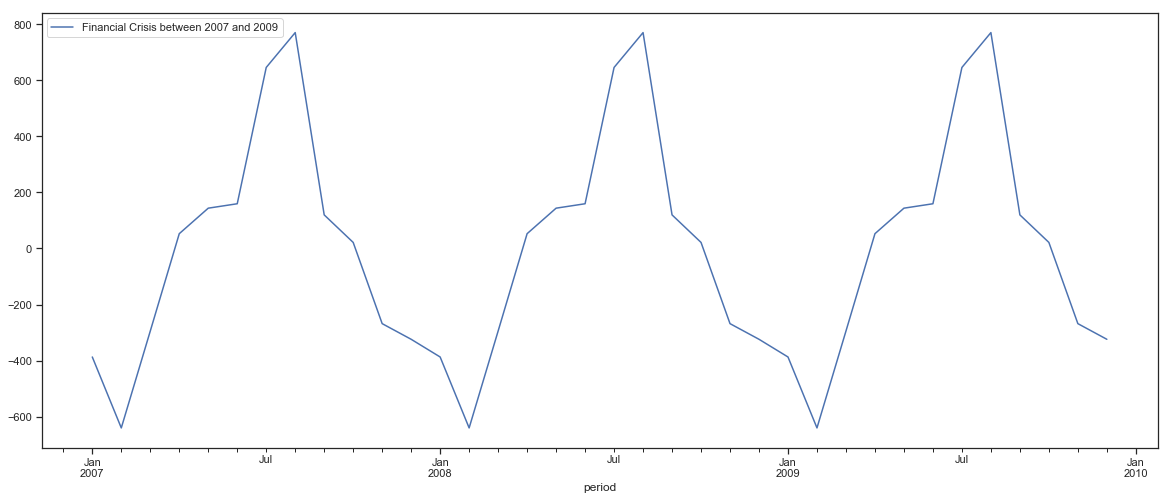

In [48]:
fig, ax = plt.subplots(figsize=(20, 8))

seasonal[crisis_zoom].plot(x="period", y="value", ax=ax, label="Financial Crisis between 2007 and 2009")

plt.legend(loc='upper left')

### Data Residual

The data residual property represents the timesearies after the trend and the seasonal components are removed. The residuals appear to be quite interesting, showing periods of less variability in the early and pikes of high variabilities in later (more recent) years of the series.

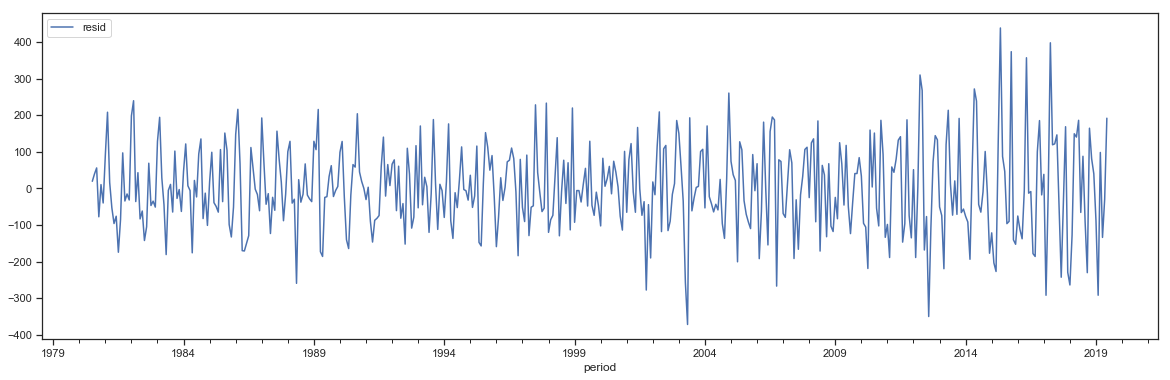

In [49]:
fig, ax = plt.subplots(figsize=(20, 6))

residual.plot(ax=ax, legend="seasonality")

plt.legend(loc='upper left')

## Data Preparation

This work checks upon stationarity of the model. The non-stationary timeseries shows seasonal effects, trends and other time-dependent repetitive structures. The data is stationary if all its statistical properties are constant over time - no clear trend, constant amplitude for variations around the mean and consistent similar fluctuations.

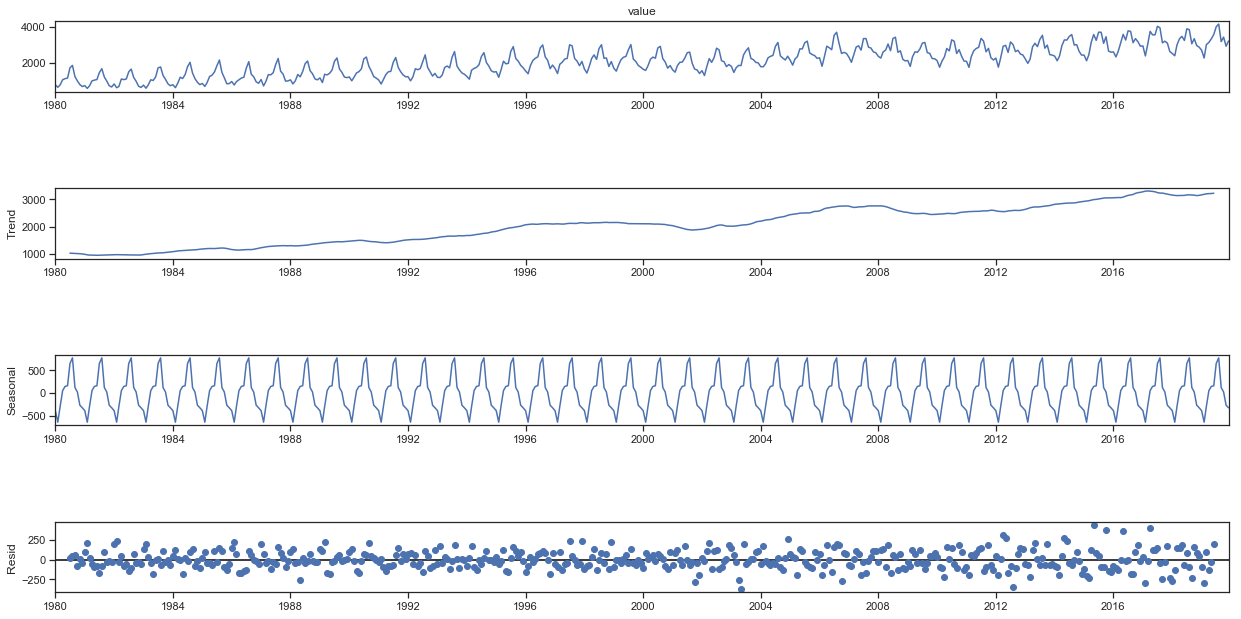

In [50]:
fig = decomp.plot()
fig.set_size_inches(20, 10)

### Data Stationarity Check
Our initiall assumption before applying a model on the timeseries is that the data does not change its probabilistic character (weak stationarity). In case of violating this assumption, there are multiple ways to correct the timeseries and allow for a model to be created using the data.

The three tests that we are going to use are:
1. Augmented Dickey-Fuller (ADF) Unit Root Test
2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for Stationarity
3. Zivot-Andrews Unit Root Test

### Augmented Dickey-Fuller (ADF) Unit Root Test
The Augmented Dickey-Fuller test is used to test for the presence of a unit root in timeseries data. The unit root is a feature of stochastic processes that causes problems for statistical inference with timeseries. The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root in the timeseries, with the alternative that there is none.

In case the ADF statistic is greater than the critical value (10%, 5% and 1% significance level), then the null hypothesis is rejected, so there is no unit root in the timeseries. Therefore, the timeseries is stationary. Our implementation looks at the resulting p-value and compares it with the significance level.

In [51]:
def is_stationary_with_adf(data, significance_level=0.01):
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    
    print("ADF p-value: {:0.5f}".format(p_value))
    
    return p_value < significance_level

### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test for Stationarity
The KPSS test for stationarity defines the null hypothesis as existing stationarity in the timeseries, while the alternative suggests that there is a unit root. The main issue of this test is that it is highly susceptible to Type I errors (ofter rejects the null hypothesis). A way of dealing with this particular disadvantage is to combine the results of KPSS and ADF (and the following Zivot-Andrews test) in order to produce a stronger conclusion for the stationarity of the timeseries. 

In [52]:
def is_stationary_with_kpss(data, significance_level=0.05):
    test = kpss(data, regression='c')
    p_value = test[1]
    
    print("KPSS p-value: {:0.5f}".format(p_value))
    
    return p_value > significance_level

### The Zivot-Andrews Unit Root Test
The Zivot-Andrews test is used to evaluate the presence of a unit root in the given timeseries data. The null hypothesis states of the test states that there exists such in the timeseries while the alternative suggests that there is no unit root in the data, which means that the timeseries is stationary. The Zivot-Andrews test performs similar work to the Augmented Dickey-Fuller Unit Root Test but the null-hypothesis for the Zivot-Andrews looks for a unit root with a signle structural break.

The algorithm follows Baum (2004/2015) approximation to original Zivot-Andrews method. Rather than performing an autolag regression at each candidate break period (as per the original paper), a single autolag regression is run up-front on the base model (constant + trend with no dummies) to determine the best lag length. This lag length is then used for all subsequent break-period regressions. This results in significant run time reduction but also slightly more pessimistic test statistics than the original Zivot-Andrews method, although no attempt has been made to characterize the size/power trade-off.

We apply the test in our case for the UK visitors data. By alligning it with the other algorithms we can either put more confidence in our final conclusion or observe a flaw in the other tests that is not present in the Zivot-Andrews algorithm. Then, we can act upon it in an appropriate manner.

*References:* <br>

Baum, C.F. (2004). ZANDREWS: Stata module to calculate Zivot-Andrews unit root test in presence of structural break,” Statistical Software Components S437301, Boston College Department of Economics, revised 2015.

Schwert, G.W. (1989). Tests for unit roots: A Monte Carlo investigation. Journal of Business & Economic Statistics, 7: 147-159.

Zivot, E., and Andrews, D.W.K. (1992). Further evidence on the great crash, the oil-price shock, and the unit-root hypothesis. Journal of Business & Economic Studies, 10: 251-270.

In [53]:
def is_stationary_with_zivot_andrews(data, significance_level=0.05):
    test = zivot_andrews(data, regression='c', autolag=None)
    p_value = test[1]
    
    print("Zivot-Andrews p-value: {:0.5f}".format(p_value))
    
    return p_value < significance_level

### Comparing Test Results
We can observe that all tests suggest agains stationarity. Therefore, we need to transform the timeseries in order to make it stationary.

In [54]:
significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.value.values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.value.values, significance_level) else "no"), '\n')

print("Stationary by Zivot-Andrews: {}".format(
    "yes" if is_stationary_with_zivot_andrews(df.value.values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.93370
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no 

Zivot-Andrews p-value: 0.57684
Stationary by Zivot-Andrews: no


### Seasonal Statistics Visualization

This visualization expresses how the seasonal rolling mean and rolling standard deviation relate to the current data. Our aim is to minimize the variation of the timeseries and making the mean constant in order to get stationary data at the end. We call this process stationarization and a way of performing it is the Box-Cox transformation.

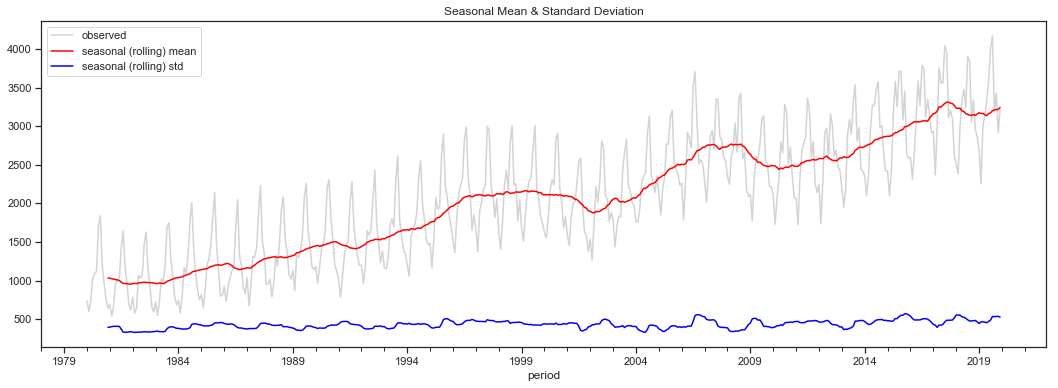

In [55]:
def visual_check(df, value, seasons):
    seasonal_mean = df.set_index("period").rolling(seasons).mean().reset_index()
    seasonal_std = df.set_index("period").rolling(seasons).std().reset_index()

    fig, ax = plt.subplots(figsize=(18,6))
    
    df.plot(x="period", y=value, ax=ax, label="observed", c='lightgrey')
    
    seasonal_mean.plot(x="period", y=value, ax=ax, label="seasonal (rolling) mean", c='red')
    seasonal_std.plot(x="period", y=value, ax=ax, label="seasonal (rolling) std", c='blue')

    plt.legend(loc='best')
    plt.title('Seasonal Mean & Standard Deviation')
    
    plt.show();
    
visual_check(df, 'value', 12)

### Stationarization

Our goal is to make the series as close to stationary as possible. There are 2 main reasons behind non-stationarity of a TS:

1. Trend – varying mean over time. For example, in this case we saw that on average, the number of visitors was growing over time.
2. Seasonality – variations at specific time-frames. For example, people might have a tendency to visit UK in a particular month because of festivals or holidays.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back. The trend (#1) can be corrected by differencing (first-difference (FD) - differencing an observation from its prior observation). The seasonal growth can be eliminated by using a log transformation or seasonal differences.

#### Box-Cox Transformation

This assignment uses the Box-Cox transformation to suppress some of the variance. This technique is used to transform non-normal dependent variables into a normal shape. The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it, the parameter needs to be estimated from the data.

Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary. Diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively.

Following, the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.

We can observe that all tests still suggest agains stationarity. Therefore we apply First-Difference (FD) and Seasonal-Difference (SD) in order to eliminate the trend and seasonality respectively.

In [56]:
df['boxcox'], lmbda = stats.boxcox(df.value)

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by Zivot-Andrews: {}".format(
    "yes" if is_stationary_with_zivot_andrews(df.boxcox.dropna().values, significance_level) else "no"))

ADF p-value: 0.88412
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no 

Zivot-Andrews p-value: 0.39855
Stationary by Zivot-Andrews: no


#### Overall Trend Elimination with First-Difference (FD)

In [57]:
df["fd"] = df.boxcox - df.boxcox.shift(1)

#### Seasonality Elimination with Seasonal-Difference (SD)

In [58]:
df["stationary"] = df.fd - df.fd.shift(12)

### Comparing Test Results
We can observe that this time all tests suggest that the trend and seasonality are gone and the timeseries is stationary. Below the results, we can see a visualization of the stationarily transformed data.

In [59]:
significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by Zivot-Andrews: {}".format(
    "yes" if is_stationary_with_zivot_andrews(df.stationary.dropna().values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.00000
Stationary by ADF: yes 

KPSS p-value: 0.10000
Stationary by KPSS: yes 

Zivot-Andrews p-value: 0.00001
Stationary by Zivot-Andrews: yes


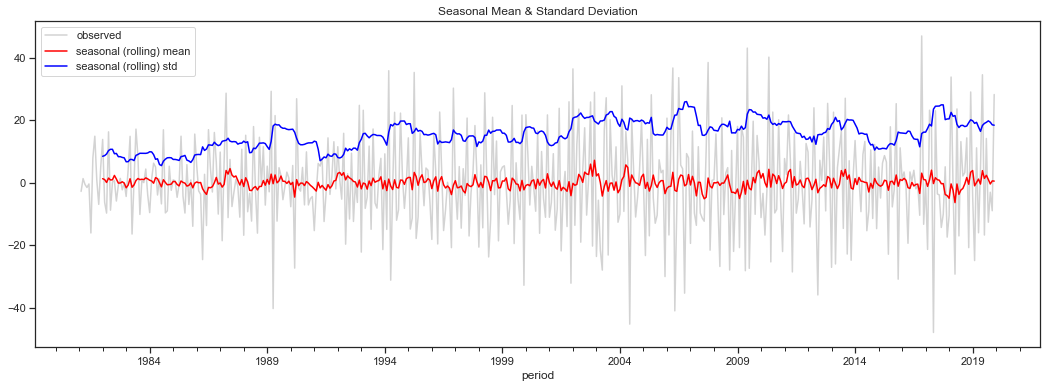

In [60]:
visual_check(df, "stationary", 12)

## Building an AutoRegressive Integrated Moving Average (ARIMA) Model

ARIMA models are denoted with the notation $ARIMA (p, d, q)$. These parameters account for seasonality, trend, and noise in datasets:

* p - the number of lag observations to include in the model, or lag order. (AR)
* d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
* q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates not to use that element of the model.

### AR / MA Parameters Estimation

After a time series has been stationarized, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

By looking at the Autocorrelation (ACF) and partial autocorrelation (PACF) functions plots of the stationarized series, we can identify the numbers of AR and/or MA terms that are needed.

At the Autocorrelation (ACF) plot there is a significant positive correlation with the 1 lag. Similarly, at the partial autocorrelation (PACF) there is a significant negative correlation with the 1 lag. However, at the PACF we can observe three strong negative correlations while there are only two at the ACF. Therefore, the starting value for the AR parameter is 1 and for the MR is also 1. We took differences of the first order to stationarize the time series, so we will try with 𝑑=1.

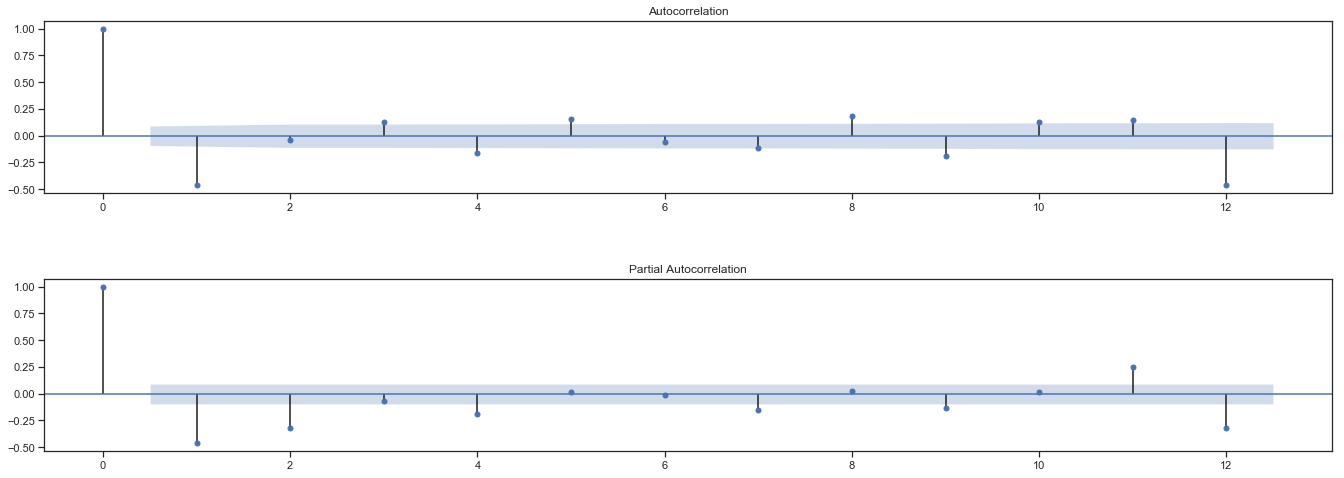

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))

fig.tight_layout(pad=5)

ax[0].set_title('Autocorrelation')
fig = plot_acf(df.stationary.dropna(inplace=False).iloc[13:], lags=12, ax=ax[0])

ax[1].set_title('Partial Autocorrelation')
fig = plot_pacf(df.stationary.dropna(inplace=False).iloc[13:], lags=12, ax=ax[1])

### Seasonal AutoRegressive Integrated Moving Average with eXogenous Regressors (SARIMAX) Model

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as  𝐴𝑅𝐼𝑀𝐴(𝑝,𝑑,𝑞)×(𝑃,𝐷,𝑄)𝑠 . Here, (p,d,q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term  𝑠  is the seasonal periodicity (4 for quarterly periods, 12 for yearly periods, etc.)

### Building the Model

The AR and MA parameters suggest 1 and 1 respectively, thus giving rise to (P, D, Q) = (1, 1, 1) respectively.

SARIMA(1,1,1)x(1,1,1) where s=12 with an intercept.


The specifing of (P,D,Q) with s in the statsmodels library is done simply by adding the **seasonal_order** argument.

* `enforce_stationarity=True` - transform the AR parameters to enforce stationarity in the autoregressive component of the model

* `enforce_invertibility=True` - transform the MA parameters to enforce invertibility in the moving average component of the model.

In [62]:
train_range = df[df.period < '2015-01-01'].index
test_range = df[(df.period >= '2015-01-01')].index

model = sarimax.SARIMAX(
    np.log(df.loc[train_range].set_index("period").value),
    trend='n',
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=True,
    enforce_invertibility=True)

results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  420
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 518.931
Date:                            Wed, 25 Mar 2020   AIC                          -1027.861
Time:                                    12:21:29   BIC                          -1007.817
Sample:                                01-01-1980   HQIC                         -1019.929
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1048      0.075      1.391      0.164      -0.043       0.252
ma.L1         -0.7102      0.051   

### Model Predictions

This section extracts the future model predictions that can be later verified on the true test set values. We can also extract the confidence interval as the model also yields that as an output. Finally, we reverse-transform the predictions, so that we can compare them to the initial data.

In [63]:
steps = test_range.shape[0]

forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()

yhat_test = np.exp(forecast.predicted_mean).values
y_test = df.loc[test_range].value.values

### Model Predictions Visualization

Here, we plot the initial train set (dark gray) and after the red dashed line, we can see the difference between the predicted values (dark blue) and the true test set values (dark gray). Overall, the predictions look very good so far but we still need to measure the numerical equivalence of the model results using specific evaluation metrics for timeseries data.

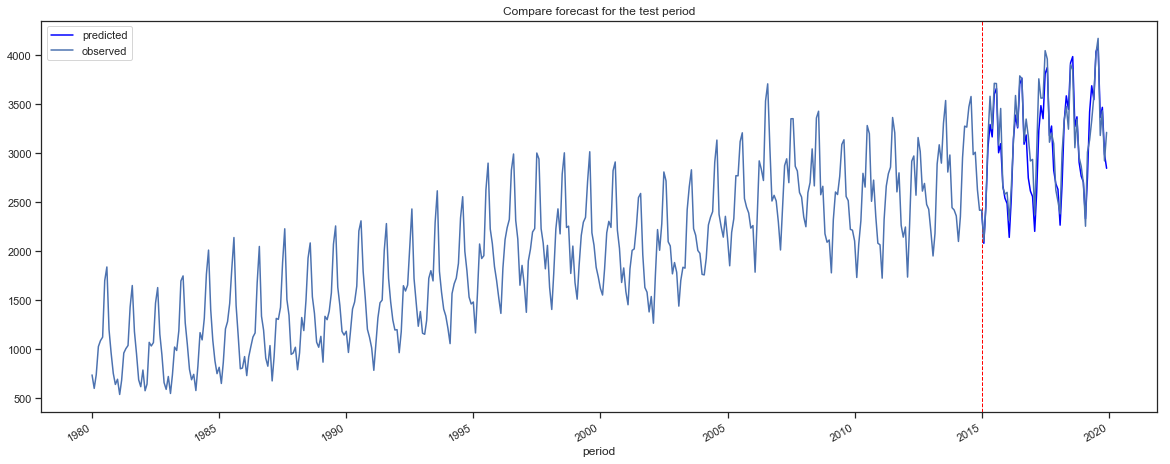

In [64]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.show()

### Model Predictions on the Test Set Visualization

This plot shows directly the prediction for the test set. The dark blue graph displays the model predictions while the dark gray - the observed (true) values for the timeseries since year 2015.

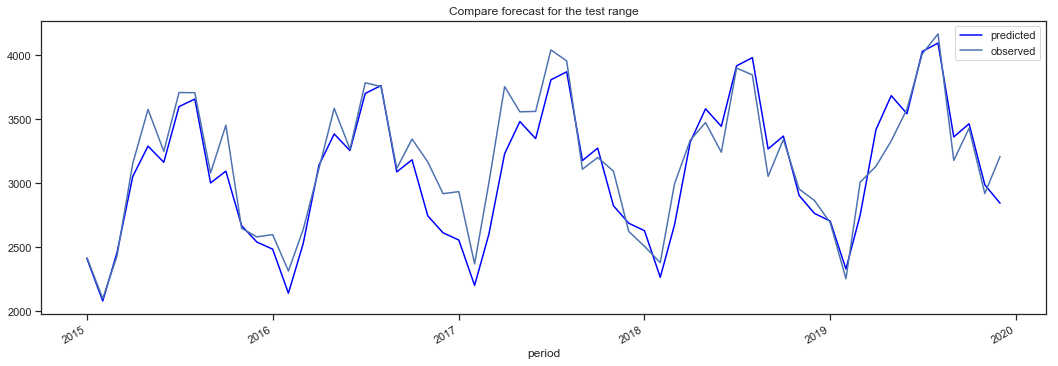

In [65]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.show()

### Model Predictions on the Test Set with Confidence Interval

This section also illustrates the prediction on the test set but this time the plot features the confidence interval for the model.

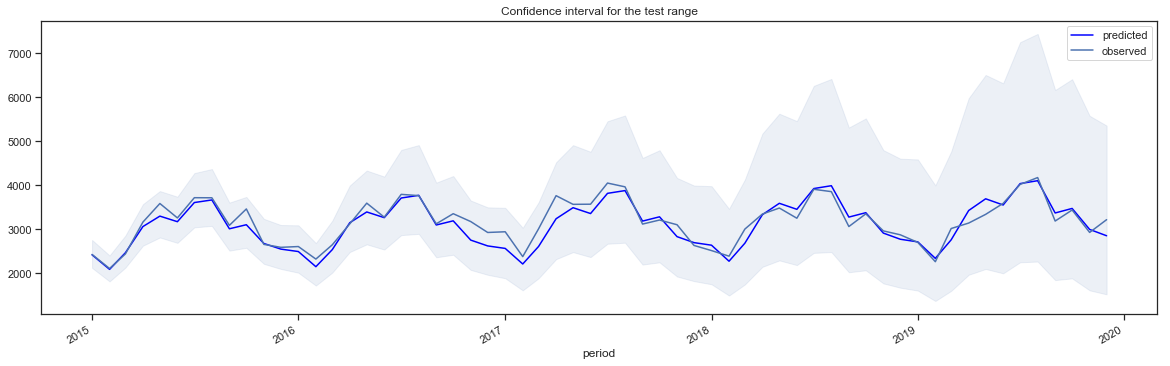

In [66]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    np.exp(forecast_ci['lower value']),
    np.exp(forecast_ci['upper value']),
    color='b',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.show()

### Model Forecast Evaluation

Report on the Mean Absolute Error (MAE), Mean Squared Error (MSE) and the Coefficient of Determination ($R^2$). 

In [67]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))

MAE (test): 143
MSE (test): 36407
R2  (test): 0.851


### Model Seasonal Prediction Evaluation (12 months)

Seasonal report on the Mean Absolute Error (MAE), Mean Squared Error (MSE) and the Coefficient of Determination ($R^2$).

In [68]:
mae = mean_absolute_error(y_test[:12], yhat_test[:12])
mse = mean_squared_error(y_test[:12], yhat_test[:12])
r2 = r2_score(y_test[:12], yhat_test[:12])

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))

MAE (test): 99
MSE (test): 21053
R2  (test): 0.926


## Clinic Conclusion

Based on the predictions plot, we can conclude that the model performs substantially good. Additionally, the three evaluation metrics provide sufficiently good scores. 

The mean absolute error, or MAE, is calculated as the average of the forecast error values, where all of the forecast values are forced to be positive. An error of 148 and 99 respectively for the Forecast and Seasonal predictions are within the acceptable range.

The mean squared error, or MSE, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive. It also has the effect of putting more weight on large errors. Very large or outlier forecast errors are squared, which drags the mean of the squared forecast errors out resulting in a larger mean squared error score. As a result, the score gives worse performance to those models that make large wrong forecasts. Although the results for the MSE seem quite high, this might not mean that the model performs bad but that there are more outlier predictions than expected. This is considered to be normal since the model cannot predict dramatic future events (e.g. pandemic, terrorist attacks, etc). After close observation, we conclude that the model performs well but we would still need to compare it with another one to make a concreate final decision.

The $R^2$ metric provides information on how much of the variability of the response data around its mean does the model explain. We can see that most of the variability is intepreted by the model (>85% at the Forecast prediction and >90% for the Seasonal Prediction), so the model fits the data sufficiently well.

This assignment looked into the data for the UK visitors from 1980 till recent times. We started with exploring the data and pointing out some periods that are essential for the UK history and might have an positive or negative effect on the observed number. Following, we tested the timeseries for stationarity and successfully applied the Box-Cox transformation as the data was non-stationary. Then, this work focused on estimating the parameters and training a SARIMAX model for the now stationary data. At the end of the clinic, we provided many visualizations about the future (and seasonal) predictions and commented on the evaluation metrics and their results. By taking a close look at the predictions (and the statistical evaluation metrics) and how they compare to the real values from the test set, we can conclude that the model would be quite useful for the tourism sector in the UK as well as for common travelers to the country.

Boss... that's one of the best models you can get and you have the best data scientist! ;)

# <center>Boss going to UK like ...</center>

<img src="https://media.giphy.com/media/321FW3n9KC9PvPqz3s/giphy.gif" width="250"/>